# Lab5

## Filip Katulski

In [1]:
from sklearn.datasets import load_iris, load_wine 
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd 
import warnings

## Gaussowski Naiwny Klasyfikator Bayesa

### Zadania 1, 2:

Klasa NaiveBayesClassifier zawiera metody słuzące do wyliczenia Naiwnego Bayesa dla zadanego zbioru danych.

Metody mean, probability, stddev, fit są wyliczane dla kazdej z zadanych klas (target). 

Dla obliczeć prawdpodobieństwa a posteriori uzyłem formuły wyprowadzonej jako suma logarytmów, wyprowadzenie [tutaj](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Multinomial_naive_Bayes) 

In [2]:
class NaiveBayesClassifier:
    # Train, Test jako Pandas Dataframe, mozliwosc uzywania funkcji groupby, apply, to_numpy.

    def calculate_means(self, train, target):
        self.means = train.groupby(target).apply(np.mean).to_numpy()

    def calculate_variances(self, train, target):
        self.vars = train.groupby(target).apply(np.var).to_numpy()

    def calculate_priors(self, train, target):
        # shape[0] zwraca ilosc elementow dla danego targetu 
        self.priors = (train.groupby(target).apply(lambda x: len(x))/train.shape[0]).to_numpy()
  
    # Zgodnie ze wzorem Eq. 5 
    def gaussian(self, x, mean, variance):
        return np.exp((-1/2)*((x - mean[:-1])**2) / (2 * variance[:-1])) / np.sqrt(2 * np.pi * variance[:-1])

    def posterior_probability(self, x):
        posteriors = []
        for i in range(len(self.classes)):
            prior = np.log(self.priors[i])
            # iloczyn jako suma logarytmow, link do wyprowadzenia powyzej 
            sub_sum_logs = np.sum(np.log(self.gaussian(x, self.means[i], self.vars[i])))
            posterior = prior + sub_sum_logs

            posteriors.append(posterior)
        
            # maksymalna wartość praw. a posteriori
        return self.classes[np.argmax(posteriors)]

    def fit(self, train, target):
        self.calculate_means(train, target)
        self.calculate_variances(train, target)
        self.calculate_priors(train, target)
        self.classes = np.unique(train[target])

    # założenie dla podzbiorów "test" - ostatnia kolumna to "target"
    def predict(self, test):
        return [self.posterior_probability(x) for x in test.to_numpy()]


### Zadanie 3

Test implementacji dla zbioru Iris

In [3]:
def accuracy(predicted, actual):
  return np.sum(predicted == actual) / len(predicted)

def error(predicted, actual):
  return 1.0 - accuracy(predicted, actual)

In [4]:
# Numpy zwraca ostrzezenia odnosnie nowej wersji niektorych funkcji, 
# zostały one wyciszone. 
warnings.filterwarnings('ignore')

iris_df= load_iris(as_frame=True)
errors = []
for iteration in range(20):
    train, test = train_test_split(iris_df['frame'], test_size=0.4)
    X_test, y_test = test.drop(columns=['target']), test['target']
    cls = NaiveBayesClassifier()
    cls.fit(train, 'target')
    predictions = cls.predict(X_test)
    errors.append(error(predictions, y_test))
    print("|Iteration: {0} \n error: {1}".format(iteration, errors[iteration]))

print("Mean error:", np.mean(errors))
print("Error variance:", np.var(errors))

|Iteration: 0 
 error: 0.033333333333333326
|Iteration: 1 
 error: 0.06666666666666665
|Iteration: 2 
 error: 0.033333333333333326
|Iteration: 3 
 error: 0.050000000000000044
|Iteration: 4 
 error: 0.08333333333333337
|Iteration: 5 
 error: 0.01666666666666672
|Iteration: 6 
 error: 0.050000000000000044
|Iteration: 7 
 error: 0.050000000000000044
|Iteration: 8 
 error: 0.06666666666666665
|Iteration: 9 
 error: 0.050000000000000044
|Iteration: 10 
 error: 0.033333333333333326
|Iteration: 11 
 error: 0.01666666666666672
|Iteration: 12 
 error: 0.050000000000000044
|Iteration: 13 
 error: 0.050000000000000044
|Iteration: 14 
 error: 0.050000000000000044
|Iteration: 15 
 error: 0.08333333333333337
|Iteration: 16 
 error: 0.050000000000000044
|Iteration: 17 
 error: 0.050000000000000044
|Iteration: 18 
 error: 0.08333333333333337
|Iteration: 19 
 error: 0.06666666666666665
Mean error: 0.051666666666666694
Error variance: 0.0003583333333333332


### Zadanie 4

Zbiór Wine. StandardScaler do standaryzacji danych wejściowych, PCA do redukcji wymiarowości.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [6]:
wine_df = load_wine(as_frame=True)

scaler = StandardScaler()
pca = PCA(n_components=2) # 2D

wine_scaled_df = pd.DataFrame(scaler.fit_transform(wine_df['frame'].drop(columns=['target'])), columns=wine_df['frame'].drop(columns=['target']).columns).join(wine_df['frame']['target'])
wine_pca_df = pd.DataFrame(pca.fit(wine_df['frame'].drop(columns=['target'])).transform(wine_df['frame'].drop(columns=['target'])), columns=['feature1', 'feature2']).join(wine_df['frame']['target'])
wine_pca_scaled_df = pd.DataFrame(pca.fit(wine_scaled_df.drop(columns=['target'])).transform(wine_scaled_df.drop(columns=['target'])), columns=['feature1', 'feature2']).join(wine_scaled_df['target']) 


In [7]:
wine_pca_scaled_df.head()

,feature1,feature2,target
0,3.316751,-1.443463,0
1,2.209465,0.333393,0
2,2.516740,-1.031151,0
3,3.757066,-2.756372,0
4,1.008908,-0.869831,0


In [8]:
def classification_wine(df):
    accuracies = []
    for iteration in range(20):
        train, test = train_test_split(df, test_size=0.3)
        X_test, y_test = test.drop(columns=['target']), test['target']
        cls = NaiveBayesClassifier()
        cls.fit(train, 'target')
        predictions = cls.predict(X_test)
        accuracies.append(accuracy(predictions, y_test))
        # print("|Iteration: {0}\n accuracy: {1}".format(iteration, accuracies[iteration]))
    print("Mean accuracy:", np.mean(accuracies))
    print("Accuracy variance:", np.var(accuracies))


In [9]:
classification_wine(wine_df['frame'])

Mean accuracy: 0.962962962962963
Accuracy variance: 0.0012002743484224967


In [10]:
classification_wine(wine_scaled_df)

Mean accuracy: 0.9499999999999998
Accuracy variance: 0.0004835390946502055


In [11]:
classification_wine(wine_pca_df)

Mean accuracy: 0.7296296296296296
Accuracy variance: 0.0029286694101508925


In [12]:
classification_wine(wine_pca_scaled_df)

Mean accuracy: 0.9638888888888888
Accuracy variance: 0.00039351851851851906


Jak widać po wynikach najlepsze rezultaty uzyskujemy po zeskalowaniu oraz redukcji wymiarów PCA: średnia wartość dokładności dla 20 iteracji wynosi 96.39%, wariancja 0.043%. 

Co ciekawe sama redukcja wymiarowości za pomocą PCA znacznie obniza dokładność.  

### Zadanie 5 

Transformacja Box-Cox, skorzystałem z modułu boxcox z biblioteki SciPy 

In [22]:
from scipy.stats import boxcox

In [23]:
boxcox_df = pd.DataFrame([])
tmp_df = wine_df['frame'].drop(columns=['target'])
for column in tmp_df.columns:
    transformed = pd.DataFrame(boxcox(tmp_df[column])[0], columns=[column])
    boxcox_df=transformed.join(boxcox_df)

boxcox_df=boxcox_df.join(wine_df['frame']['target'])  

In [24]:
boxcox_df.head()

,proline,od280/od315_of_diluted_wines,hue,color_intensity,proanthocyanins,nonflavanoid_phenols,flavanoids,total_phenols,magnesium,alcalinity_of_ash,ash,malic_acid,alcohol,target
0,4.968741,4.035440,0.039910,1.848571,1.057792,-1.078493,1.734838,1.496316,0.699041,8.226937,1.787608,0.498435,21.927545,0
1,4.961832,3.188416,0.049860,1.563014,0.264986,-1.130654,1.508768,1.386825,0.698760,6.245109,1.374804,0.532808,19.868336,0
2,5.020418,2.828647,0.029949,1.856632,1.405015,-1.028992,1.867648,1.496316,0.698774,9.478776,2.145671,0.763944,19.789201,0
3,5.126201,3.267868,-0.141185,2.222884,0.980108,-1.185841,2.048911,2.217519,0.698915,8.735865,1.890549,0.609549,22.210560,0
4,4.784747,2.463578,0.039910,1.547593,0.713148,-0.832162,1.455100,1.496316,0.698964,10.435768,2.454813,0.836270,19.947535,0


In [25]:
classification_wine(boxcox_df)


Mean accuracy: 0.9685185185185183
Accuracy variance: 0.00038065843621399236


Uzyskano nieznacznie lepsze wyniki dla transformacji Box-Cox niz dla skalowania + PCA. 

## Liniowa Regresja Bayesowska

### Zadania 1, 2: 

Przetworzona klasa pomocnicza, korzysta z modułu scipy.stats  

Zbiór "Boston" nie moze zostać zaimportowany z biblioteki scikit-learn w wersji 1.2. W tracie wykonywnia ćwiczenia przełączyłem się na wersję 1.1.3. 

In [13]:
# sklearn 1.1.3
from sklearn.datasets import load_boston

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from math import fabs 
from sklearn.metrics import r2_score, f1_score 

In [15]:
class BayesianLinearRegression:
  def __init__(self, n_features, alpha, beta):
    self.n_features = n_features
    self.alpha = alpha
    self.beta = beta
    self.mean = np.zeros(n_features)
    self.cov = np.identity(n_features) * alpha

  def learn(self, x, y):
    # inverse covariance matrix
    cov_inv = np.linalg.inv(self.cov)
    self.cov = np.linalg.inv(cov_inv + self.beta * x.T @ x)
    # update mean vector
    self.mean = self.cov @ (cov_inv @ self.mean + self.beta * x.T @ y)
    return self

  def predict(self, x):
    # predictive mean 
    y_pred_mean = self.mean.T @ x
    # predictive variance
    y_pred_var = 1 / self.beta + x.T @ self.cov @ x
    return norm(loc=y_pred_mean, scale=y_pred_var ** .5)

  @property
  def weights_dist(self):
    return multivariate_normal(mean=self.mean, cov=self.cov)


In [18]:
boston_df = load_boston()
boston_df

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [20]:
boston_data = boston_df['data']
boston_target = boston_df['target']
num_features = len(boston_data[0])

In [24]:
blr = BayesianLinearRegression(n_features=num_features, alpha=0.3, beta=1.0)
errors = []
predictions = []

for i in range(len(boston_data)):
    blr.learn(x=np.array([boston_data[i]]), y=np.array([boston_target[i]]))
    prediciton = blr.predict(boston_data[i]).mean()
    predictions.append(prediciton)
    actual = boston_target[i]
    # fabs returns absolute value 
    errors.append(fabs(prediciton - actual))
    print("|Iteration: {0}\n prediction: {1}\n error: {2}".format(i, prediciton, fabs(prediciton - actual)))



|Iteration: 0
 prediction: 23.99968006340752
 error: 0.0003199365924793085
|Iteration: 1
 prediction: 21.60121646283332
 error: 0.0012164628333195537
|Iteration: 2
 prediction: 34.53017129887457
 error: 0.16982870112543225
|Iteration: 3
 prediction: 33.76761854909454
 error: 0.3676185490945443
|Iteration: 4
 prediction: 32.87870413667265
 error: 3.32129586332735
|Iteration: 5
 prediction: 29.438003253309514
 error: 0.7380032533095147
|Iteration: 6
 prediction: 23.039017563208127
 error: 0.13901756320812808
|Iteration: 7
 prediction: 23.622534349359952
 error: 3.477465650640049
|Iteration: 8
 prediction: 17.075906083265252
 error: 0.5759060832652523
|Iteration: 9
 prediction: 21.39640202965633
 error: 2.4964020296563305
|Iteration: 10
 prediction: 19.44767354348921
 error: 4.447673543489209
|Iteration: 11
 prediction: 21.04184715550961
 error: 2.1418471555096126
|Iteration: 12
 prediction: 22.84598426137443
 error: 1.14598426137443
|Iteration: 13
 prediction: 20.54369768964301
 error: 0

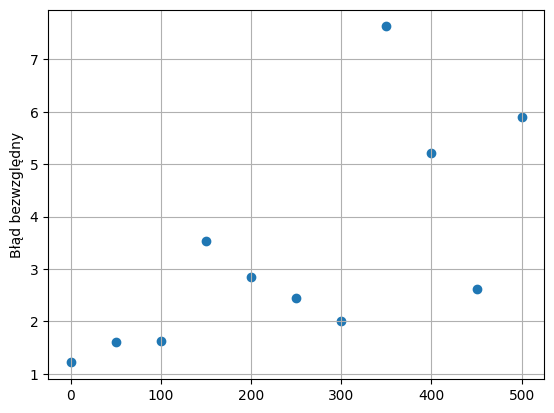

R2 score: 0.7495096908919272


In [38]:
# by ustalić krok na 50
step = 50
errors_mean = []
actual = []

for err in errors:
  actual.append(err)
  if len(actual) == step:
    errors_mean.append(sum(actual)/len(actual))
    actual = []

errors_mean.append(sum(actual)/len(actual))

plt.scatter(range(0, len(boston_data), step), errors_mean)
plt.ylabel("Błąd bezwzględny")
plt.grid()
plt.show()

print("R2 score:",r2_score(boston_target, predictions))

Powyżej przedstawiono średnią dla błędów bezwzględnych przy kolejnych krokach oraz wartość metryki R2.

### Zadanie 3

In [39]:
def t_with_noise(x):
    return -0.2 + 0.6 * x + np.random.normal(0.0, 0.2)

def t(x):
    return -0.2 + 0.6 * x

#random X points:
xs = np.random.uniform(size=10) * 2 - 1
ys = [t(x) for x in xs]
# random Ys:
ys_with_noise = [t_with_noise(x) for x in xs]
data_points = list(zip(xs, ys_with_noise))


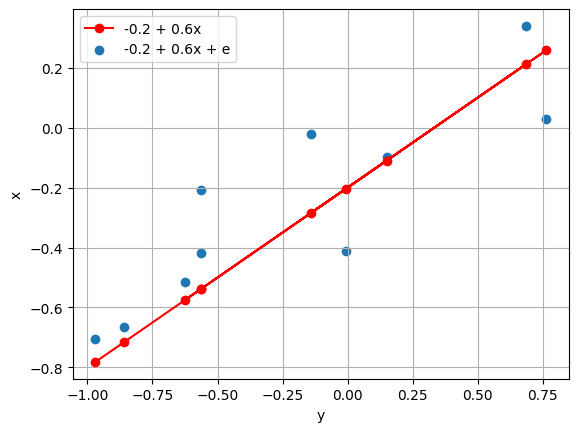

In [46]:
plt.plot(xs, ys, color='r', marker='o', label="-0.2 + 0.6x")
plt.scatter(xs, ys_with_noise, label="-0.2 + 0.6x + e")
plt.xlabel("y")
plt.ylabel("x")
plt.grid()
plt.legend()
plt.show()


### Zadanie 4

In [49]:
def plot_distribution(blr, title):
    x, y = np.mgrid[-1.:1.:.01, -1.:1.:.01]
    pos = np.dstack((x, y))
    plt.contourf(x, y, blr.weights_dist.pdf(pos), levels=15)
    plt.title(title)
    plt.xlabel("w1")
    plt.ylabel("w2")
    plt.plot(-0.2, 0.6, 'o', color='r')
    plt.show()

def plot_predictive_distribution(blr, title, data):
    plt.plot([-1, 1], [-0.8, 0.4], color='b')
    X = list(map(lambda x: x[0], data))
    Y = list(map(lambda x: x[1], data))

    space = np.linspace(-1, 1, 100)
    y1 = []
    y2 = []

    for x in space:
        norm = blr.predict(np.array([1, x]))
        pred = norm.mean()
        std = norm.std()
        y1.append(pred + std)
        y2.append(pred - std)

    plt.fill_between(space, y1, y2, alpha=0.2)
    plt.scatter(X, Y, color='r')
    plt.grid()
    plt.title(title)
    plt.show()

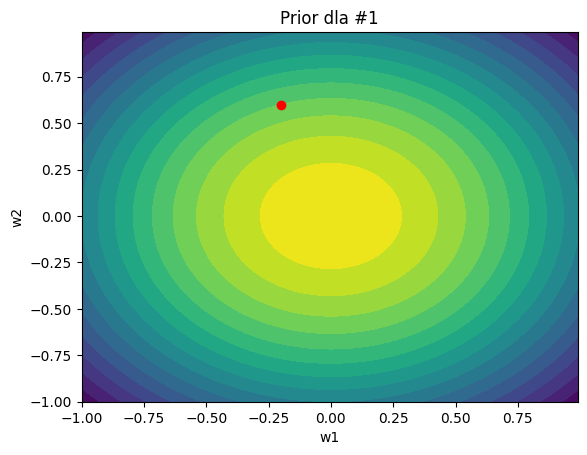

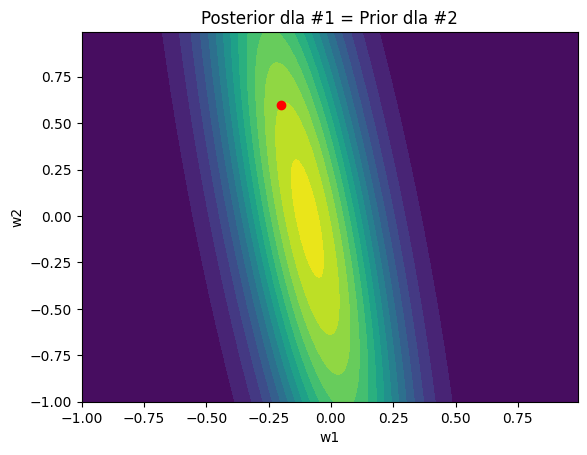

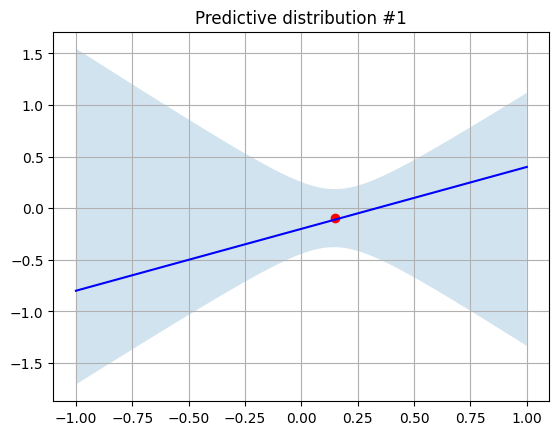

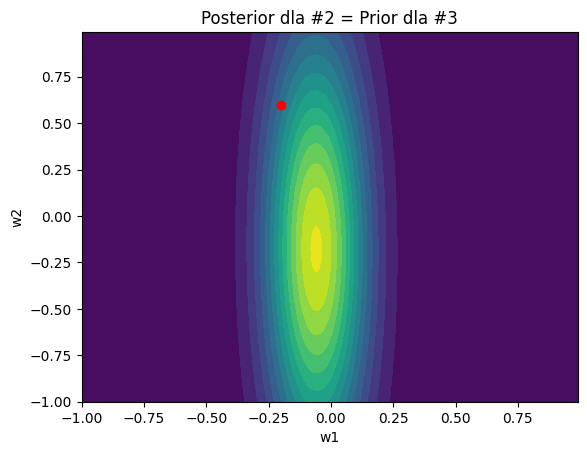

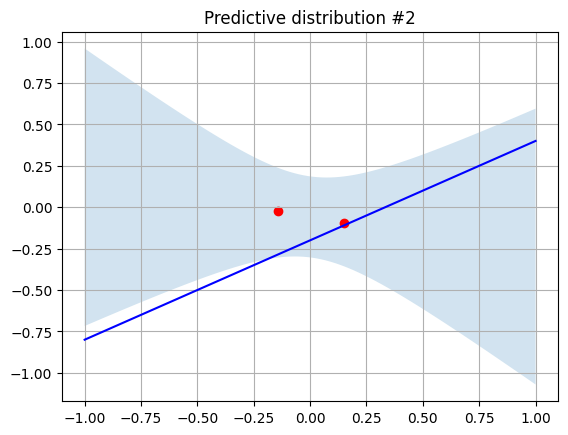

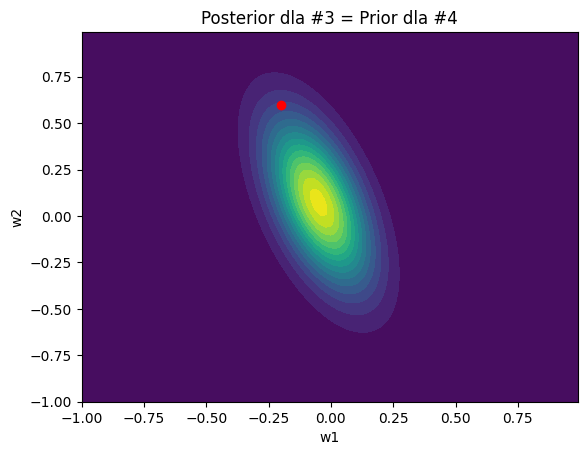

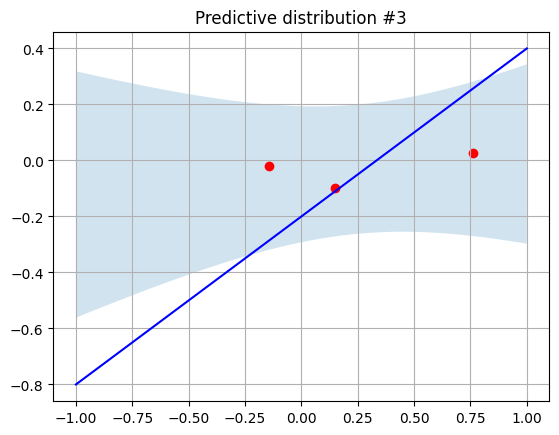

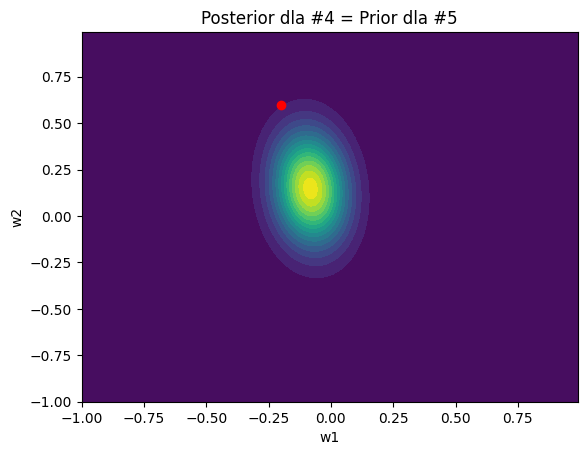

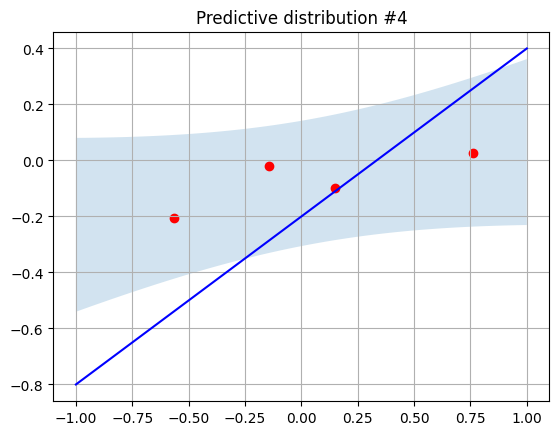

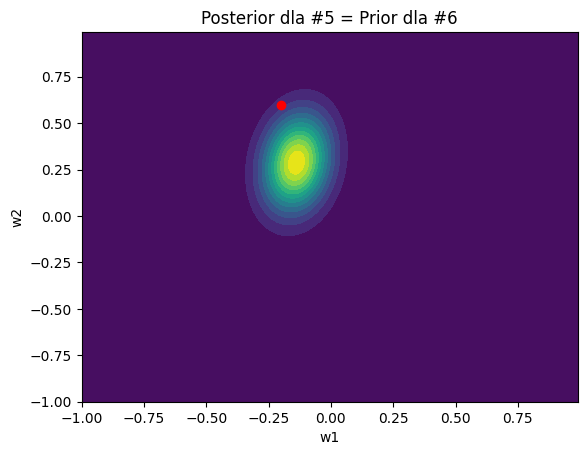

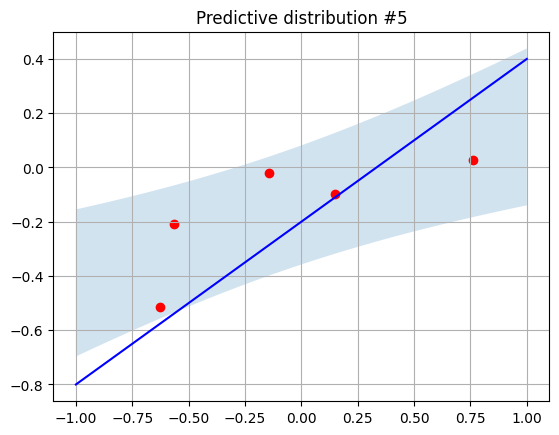

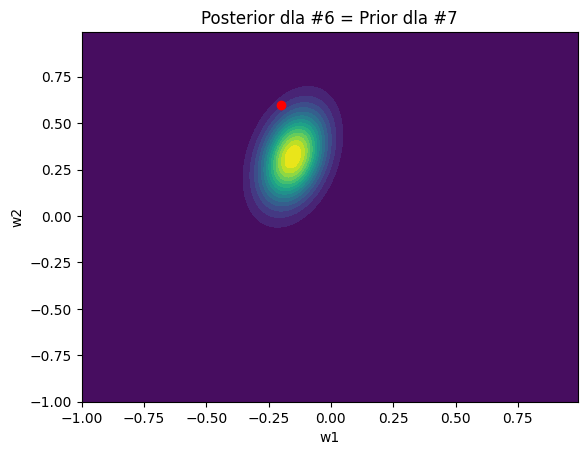

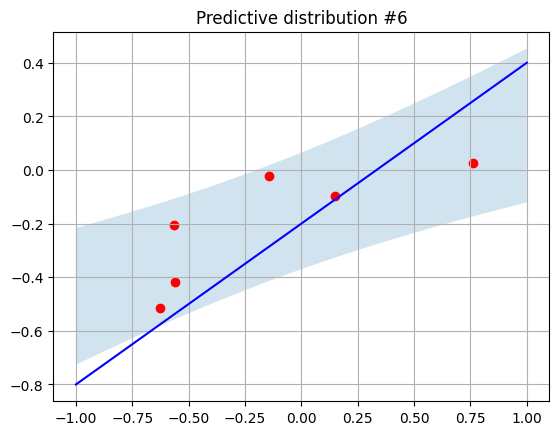

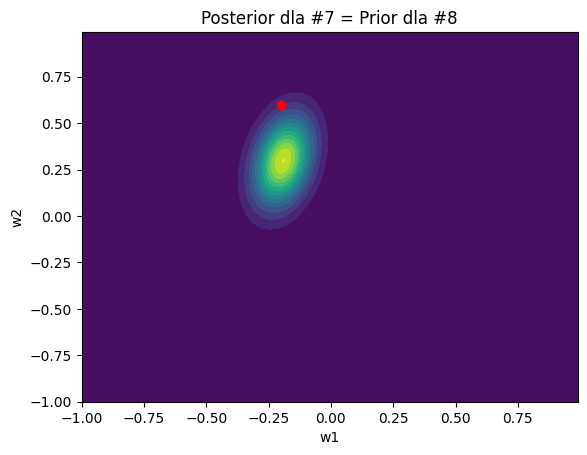

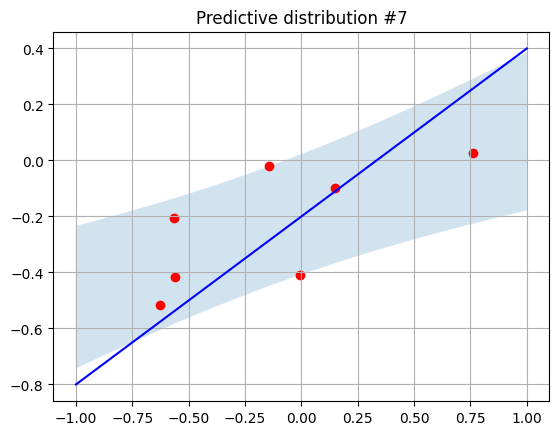

In [52]:
blr = BayesianLinearRegression(n_features=2, alpha=2, beta=25)

plot_distribution(blr, f"Prior dla #{1}")


for index, d in enumerate(data_points[:7]):
    blr.learn(np.array([np.array([1,d[0]])]), np.array([d[1]]))
    plot_distribution(blr, f"Posterior dla #{index + 1} = Prior dla #{index + 2}")
    plot_predictive_distribution(blr, f"Predictive distribution #{index + 1}", data_points[:index+1])


### Zadanie 5

Rozkład 'a posteriori' coraz bardziej się zawęża i skupia wokół szukanych współczynników (w1, w2).